## Търсене и извличане на информация. Приложение на дълбоко машинно обучение
> ### Стоян Михов
> #### Зимен семестър 2021/2022

### Упражнение 6

 За да работи програмата трябва корпуса от публицистични текстове за Югоизточна Европа,
 да се намира разархивиран в директорията, в която е програмата (виж упражнение 2).

 Преди да се стартира програмата е необходимо да се активира съответното обкръжение с командата: `conda activate tii`
 
 Настоящата програма използва библиотеката sklearn.
 За да я инсталирате, след активиране на обкръжението трябва да изпълните командата: `conda install scikit-learn`

In [1]:
import nltk
from nltk.corpus import PlaintextCorpusReader
import sys
import random
import math
import pprint

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import numpy as np
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import TruncatedSVD

class progressBar:
    def __init__(self ,barWidth = 50):
        self.barWidth = barWidth
        self.period = None
    def start(self, count):
        self.item=0
        self.period = int(count / self.barWidth)
        sys.stdout.write("["+(" " * self.barWidth)+"]")
        sys.stdout.flush()
        sys.stdout.write("\b" * (self.barWidth+1))
    def tick(self):
        if self.item>0 and self.item % self.period == 0:
            sys.stdout.write("-")
            sys.stdout.flush()
        self.item += 1
    def stop(self):
        sys.stdout.write("]\n")

In [2]:
def extractDictionary(corpus, limit=20000):
    pb = progressBar()
    pb.start(len(corpus))
    dictionary = {}
    for doc in corpus:
        pb.tick()
        for w in doc:
            if w not in dictionary: dictionary[w] = 0
            dictionary[w] += 1
    L = sorted([(w,dictionary[w]) for w in dictionary], key = lambda x: x[1] , reverse=True)
    if limit > len(L): limit = len(L)
    words = [ w for w,_ in L[:limit] ]
    word2ind = { w:i for i,w in enumerate(words)}
    pb.stop()
    return words, word2ind

In [3]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
startToken = '<START>'
endToken = '<END>'
corpus =  [[startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in myCorpus.fileids()]

In [4]:
ws,wi=extractDictionary(corpus,limit=200)

[                                                  --------------------------------------------------]


In [5]:
ws[120:130]

['военни',
 'президент',
 'няма',
 'правителство',
 'херцеговина',
 'този',
 'преди',
 'или',
 'при',
 'ако']

In [6]:
ws[wi['президент']]

'президент'

In [7]:
def co_occurrence_matrix(corpus, window_size=4, limit=20000):
    words, word2ind = extractDictionary(corpus,limit=limit)
    num_words = len(words)
    
    X=np.zeros((num_words,num_words))
    
    pb = progressBar()
    pb.start(len(corpus))
    for doc in corpus:
        pb.tick()
        for wi in range(len(doc)):
            if doc[wi] not in word2ind: continue
            i=word2ind[doc[wi]]
            for k in range(1,window_size+1):
                if wi-k>=0 and doc[wi-k] in word2ind:
                    j=word2ind[doc[wi-k]]
                    X[i,j] += 1
                if wi+k<len(doc) and doc[wi+k] in word2ind:
                    j=word2ind[doc[wi+k]]
                    X[i,j] += 1
    pb.stop()
    return X, words, word2ind

##### Какъв е смисъла на един ред от `co_occurrence_matrix` матрицата?

In [8]:
def PCA_k_dim(X, k=2):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html

    print("Running Incremental PCA over %i words..." % (X.shape[0]))
    X0 = X - np.mean(X, axis=0)
    pca = IncrementalPCA(n_components=k)
    pca.fit(X0)
    X_reduced = pca.transform(X0)
    print("Done.")
    return X_reduced

In [9]:
def SVD_k_dim(X, k=100, n_iters = 10):
    # Документация на метода има на https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
    print("Running Truncated SVD over %i words..." % (X.shape[0]))
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    svd.fit(X)
    X_reduced = svd.transform(X)
    print("Done.")
    return X_reduced

In [10]:
def plot_embeddings(M, word2ind, words):
    xs = M[:,0]
    ys = M[:,1]
    for w in words:
        i=word2ind[w]
        plt.scatter(xs[i],ys[i], marker='x', color= 'red')
        plt.text(xs[i]+0.001, ys[i]+0.001, w)
    plt.show()

In [11]:
def plot_embeddings_3d(M, word2ind, words):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = M[:,0]
    ys = M[:,1]
    zs = M[:,2]
    for w in words:
        i=word2ind[w]
        ax.scatter(xs[i], ys[i], zs[i], marker='x', color= 'red')
        ax.text(xs[i]+0.001, ys[i]+0.001, zs[i]+0.001, w)
    plt.show()

####   Малък пример

In [12]:
text = '''
    две хубави очи душата на дете
    в две хубави очи музика лъчи
    не искат и не обещават те
    душата ми се моли
    дете
    душата ми се моли
    страсти и неволи
    ще хвърлят утре върху тях
    булото на срам и грях
    булото на срам и грях
    не ще го хвърлят върху тях
    страсти и неволи
    душата ми се моли
    дете
    душата ми се моли
    не искат и не обещават те
    две хубави очи музика лъчи
    в две хубави очи душата на дете
    '''

In [13]:
CC,ccww,ccwi = co_occurrence_matrix([text.split()], window_size=1, limit=10); ccww

[                                                  ]
[                                                  ]


['душата', 'и', 'не', 'две', 'хубави', 'очи', 'на', 'дете', 'ми', 'се']

In [14]:
CC

array([[0., 0., 0., 0., 0., 2., 2., 2., 4., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0., 4., 0., 0., 0., 0.],
       [2., 0., 0., 0., 4., 0., 0., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [2., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 4., 0.]])

In [15]:
CC_reduced = SVD_k_dim(CC,k=3)

Running Truncated SVD over 10 words...
Done.


In [16]:
CC_reduced

array([[ 3.60985286e+00,  3.26876129e+00, -1.16384688e+00],
       [-1.92627854e-17, -2.66661908e-17, -2.21501065e-16],
       [ 0.00000000e+00,  1.11022302e-16,  1.76941795e-16],
       [ 1.31466049e+00, -1.58193926e+00,  2.46440278e+00],
       [ 2.20685720e+00,  2.56854783e+00,  3.32942363e+00],
       [ 2.38988433e+00, -2.58853562e+00,  2.03366945e+00],
       [ 1.53134830e+00, -7.69601866e-01, -6.83806280e-01],
       [ 1.53134830e+00, -7.69601866e-01, -6.83806280e-01],
       [ 3.33339555e+00, -3.24352102e+00, -1.90539288e+00],
       [ 1.98575759e+00,  1.99764754e+00, -1.41035087e+00]])

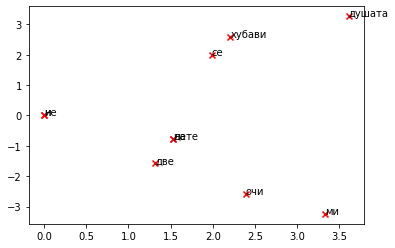

In [17]:
plot_embeddings(CC_reduced, ccwi, ccww)

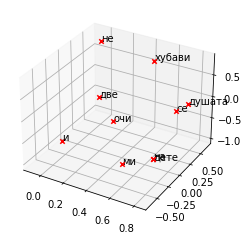

In [18]:
# Документация за np.linalg.norm има на https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
CC_lengths = np.linalg.norm(CC_reduced, axis=1)[:, np.newaxis]
CC_normalized = CC_reduced / CC_lengths
plot_embeddings_3d(CC_normalized, ccwi, ccww)

##### Пълен пример

In [19]:
corpus_root = '../JOURNALISM.BG/C-MassMedia'
myCorpus = PlaintextCorpusReader(corpus_root, '.*\.txt')
startToken = '<START>'
endToken = '<END>'
corpus =  [[startToken] + [w.lower() for w in myCorpus.words(f)] + [endToken] for f in myCorpus.fileids()]

In [20]:
C, words, word2ind = co_occurrence_matrix(corpus)

[                                                  --------------------------------------------------]
[                                                  --------------------------------------------------]


In [21]:
C.shape

(20000, 20000)

In [22]:
words[127:132]

['или', 'при', 'ако', 'страна', 'петък']

In [23]:
c=C[127:132,127:132];c

array([[312.,  53.,  96.,  66.,   9.],
       [ 53.,  46.,  22.,  35.,  28.],
       [ 96.,  22.,  10.,  45.,   8.],
       [ 66.,  35.,  45.,  28.,  18.],
       [  9.,  28.,   8.,  18.,   0.]])

In [24]:
C_reduced = SVD_k_dim(C)

Running Truncated SVD over 20000 words...
Done.


In [25]:
C_reduced.shape

(20000, 100)

In [26]:
C_reduced_2d = C_reduced[:,:2]
C_lengths_2d = np.linalg.norm(C_reduced_2d, axis=1)
C_normalized_2d = C_reduced_2d / C_lengths_2d[:, np.newaxis]

In [27]:
sampleWords = ['кола', 'автомобил', 'румъния', 'министър', 'президент', 'гърция', 'футбол', 'спорт', 'баскетбол', 'българия', 'театър', 'кино', 'опера']

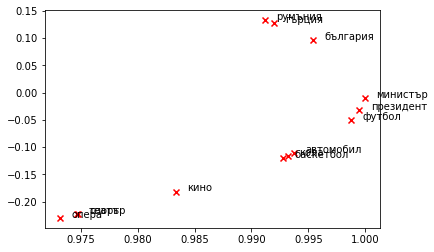

In [28]:
plot_embeddings(C_normalized_2d, word2ind, sampleWords)

In [29]:
C_reduced_3d = C_reduced[:,:3]
C_lengths_3d = np.linalg.norm(C_reduced_3d, axis=1)
C_normalized_3d = C_reduced_3d / C_lengths_3d[:, np.newaxis]

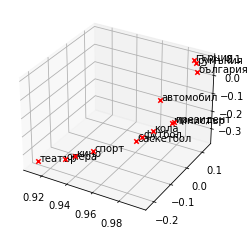

In [30]:
plot_embeddings_3d(C_normalized_3d, word2ind, sampleWords)

In [31]:
def PMI_matrix(C):
    rowSums = np.sum(C,axis=1)
    colSums = np.sum(C,axis=0)
    D = np.sum(rowSums)
    Z = np.outer(rowSums,colSums)
    # p(x,y)/(p(x)*p(y)) = (C[x,y]/D)/( (sum(C[x,:])/D) * (sum(C[:,y])/D) )
    X = np.maximum(np.log( D * C / Z),0) # minmax на pmi защо режем?
    return X

In [32]:
np.seterr(divide = 'ignore'); 

In [33]:
PMI_matrix(c)

array([[0.22745591, 0.        , 0.13443805, 0.        , 0.        ],
       [0.        , 0.45149093, 0.        , 0.13563798, 1.02685508],
       [0.13443805, 0.        , 0.        , 0.40339114, 0.        ],
       [0.        , 0.13563798, 0.40339114, 0.        , 0.54246271],
       [0.        , 1.02685508, 0.        , 0.54246271, 0.        ]])

In [ ]:
X = PMI_matrix(C)

In [ ]:
X.shape

In [ ]:
X_reduced = SVD_k_dim(X);X_reduced

In [ ]:
X_reduced_3d = X_reduced[:,:3]
X_lengths_3d = np.linalg.norm(X_reduced_3d, axis=1)
X_normalized_3d = X_reduced_3d / X_lengths_3d[:, np.newaxis]

In [ ]:
plot_embeddings_3d(X_normalized_3d, word2ind, sampleWords)

In [ ]:
C_lengths_100d = np.linalg.norm(C_reduced, axis=1)
C_normalized_100d = C_reduced / C_lengths_100d[:, np.newaxis]

In [ ]:
X_lengths_100d = np.linalg.norm(X_reduced, axis=1)
X_normalized_100d = X_reduced / X_lengths_100d[:, np.newaxis]

In [ ]:
def most_similar(w,word2ind,words,C,limit=10):
    i = word2ind[w]
    L = np.dot(C,C[i]).tolist() # cosine similarity
    L = sorted([(words[i],s) for i,s in enumerate(L)], key = lambda x: x[1] , reverse=True)
    return L[:limit]

In [ ]:
pprint.pprint(most_similar('гърция',word2ind,words,C_normalized_100d))

In [ ]:
pprint.pprint(most_similar('гърция',word2ind,words,X_normalized_100d))

In [ ]:
pprint.pprint(most_similar('футбол',word2ind,words,C_normalized_100d))

In [ ]:
pprint.pprint(most_similar('футбол',word2ind,words,X_normalized_100d))

In [ ]:
pprint.pprint(most_similar('камион',word2ind,words,C_normalized_100d))

In [ ]:
pprint.pprint(most_similar('камион',word2ind,words,X_normalized_100d))

##### 